In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [99]:
def find_num_of_decks_scored(filename):
    n = filename.split('=')[1]
    return n

def load_scoring_analysis(path):
    df = pd.read_csv(path, converters = {'p1': str, 'p2' : str})
    df["p1"] = df["p1"].str.replace('0', 'B').str.replace('1', 'R')
    df["p2"] = df["p2"].str.replace('0', 'B').str.replace('1', 'R')
    return df

def calculate(p1_wins: str, p2_wins: str, draws: str, df: pd.DataFrame):
    df["total_wins"] = df[p1_wins] + df[p2_wins] + df[draws]
    df["p1_win_rate"] = df[p1_wins] / df["total_wins"]
    df["draw_rate"] = df[draws] / df["total_wins"]
    df["p1_win_rate"] = df["p1_win_rate"].round(2)
    df["draw_rate"] = df["draw_rate"].round(2)
    return df


def matrix(df):
    # Step 3: Create a pivot table with formatted annotations
    # Format: "P1% (Draw%)"
    df["annotation"] = df.apply(lambda row: f'{int(row["p1_win_rate"]*100)} ({int(row["draw_rate"]*100)})', axis=1)

    # Get unique p1 and p2 combinations for axes
    p1_values = sorted(df["p1"].unique())
    p2_values = sorted(df["p2"].unique())

    # Create a matrix of annotations
    annotation_matrix = pd.DataFrame(index=p1_values, columns=p2_values)
    print(p1_values, p2_values)

    # Fill in the matrix with our formatted annotations
    for _, row in df.iterrows():
        annotation_matrix.loc[row["p1"], row["p2"]] = row["annotation"]

    # Also create a matrix of numerical values for coloring (just the win rate)
    value_matrix = df.pivot(index="p1", columns="p2", values="p1_win_rate")

    return value_matrix, annotation_matrix


def blackbox(value_matrix, ax):
    for row_idx in value_matrix.index:
        row = value_matrix.loc[row_idx]
        max_cols = row[row == row.max()].index  # Handles ties if needed

        for col_idx in max_cols:
            ax.add_patch(
                patches.Rectangle(
                    (value_matrix.columns.get_loc(col_idx), value_matrix.index.get_loc(row_idx)),
                    1, 1, fill=False, edgecolor='black', lw=3
                )
            )

def heatmap(path: str, t_or_c: str = 'tricks'):
    N = find_num_of_decks_scored(path)

    df = load_scoring_analysis(path)
    if t_or_c == 'tricks':
        df = calculate('p1_wins_tricks', 'p2_wins_tricks', 'draws_tricks', df)
    elif t_or_c == 'cards':
        df = calculate('p1_wins_cards', 'p2_wins_cards', 'draws_cards', df)
    else:
        raise ValueError("Invalid input")
    
    value_matrix, annotation_matrix = matrix(df)

    cmap = sns.color_palette("YlOrBr", as_cmap=True)
    cmap.set_bad(color='lightgray')
    masked_matrix = value_matrix.mask(value_matrix == -1)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(masked_matrix, annot=annotation_matrix, fmt='', cmap=cmap, cbar=False, linewidths = 1, linecolor = 'white')

    blackbox(value_matrix, ax)

    # Optional: Titles and labels
    plt.title(f"My Chance of Win(Draw) \nby {t_or_c} \nN={N}")
    plt.ylabel("Opponent choice")
    plt.xlabel("My choice")
    plt.tight_layout()
    plt.show()

['BBB', 'BBR', 'BRB', 'BRR', 'RBB', 'RBR', 'RRB', 'RRR'] ['BBB', 'BBR', 'BRB', 'BRR', 'RBB', 'RBR', 'RRB', 'RRR']


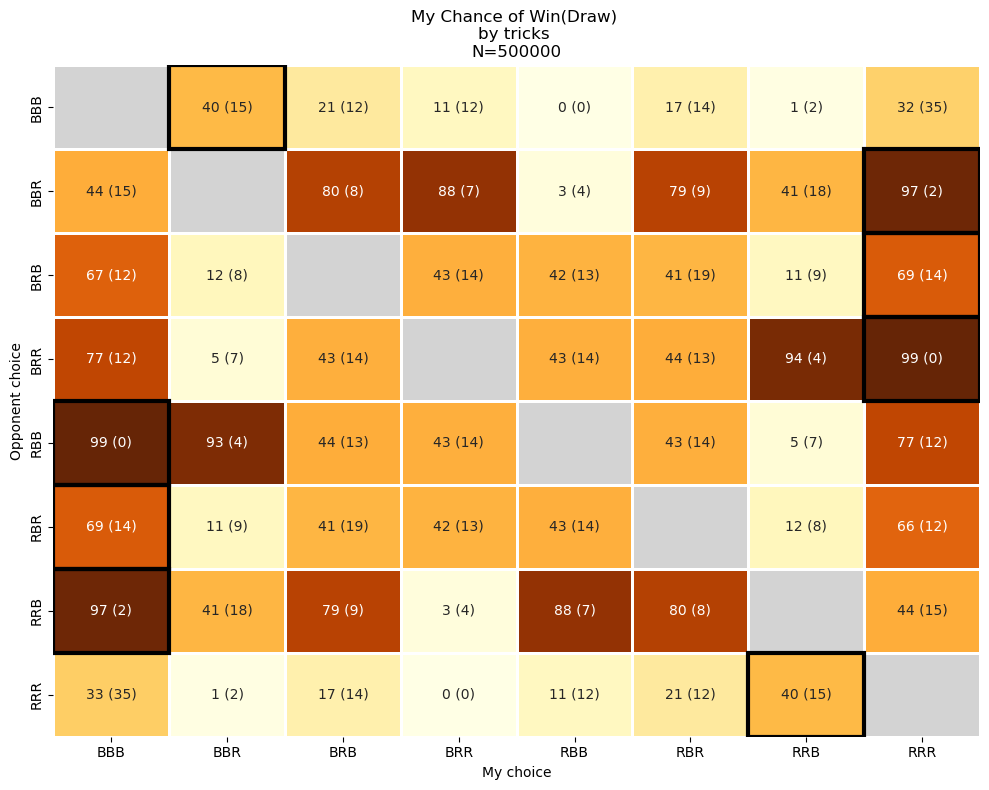

In [100]:
heatmap(path = "C:/Users/kmand/DATA 440/Penney-Game/outputs/scoring_analysis_N=500000", t_or_c = 'tricks')